# Notebook for classification of genders
This is a demonstration of gender classification with the usage of Keras and mobilenet

In [0]:
#!kill -9 -1

### Connect with drive to use resources
You can skip this step

In [0]:
#Connect with drive

from google.colab import drive
drive.mount('/content/drive')

### Fetch the specific zip either from the drive or your pc.
After that unzip it

In [1]:
!wget https://services.anifantakis.eu/deep-learning/genderdetectionface.zip
!unzip genderdetectionface.zip

--2019-04-18 13:36:28--  https://services.anifantakis.eu/deep-learning/genderdetectionface.zip
Resolving services.anifantakis.eu (services.anifantakis.eu)... 104.18.56.65, 104.18.57.65, 2606:4700:30::6812:3941, ...
Connecting to services.anifantakis.eu (services.anifantakis.eu)|104.18.56.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71148325 (68M) [application/zip]
Saving to: ‘genderdetectionface.zip’

genderdetectionface 100%[===================>]  67.85M  13.2MB/s    in 5.9s    

2019-04-18 13:36:35 (11.4 MB/s) - ‘genderdetectionface.zip’ saved [71148325/71148325]

Archive:  genderdetectionface.zip
   creating: dataset1/test/
   creating: dataset1/test/man/
  inflating: dataset1/test/man/face_0.jpg  
  inflating: dataset1/test/man/face_1.jpg  
  inflating: dataset1/test/man/face_10.jpg  
  inflating: dataset1/test/man/face_101.jpg  
  inflating: dataset1/test/man/face_103.jpg  
  inflating: dataset1/test/man/face_104.jpg  
  inflating: dataset1/test/man

Load folders and divide them in files and targets

In [0]:
'Load and view files'
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

'define function to load train, test, and validation datasets'
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dataset1/train')
valid_files, valid_targets = load_dataset('dataset1/valid')
test_files, test_targets = load_dataset('dataset1/test')

# load ordered list of dog names
dog_names = [item[25:-1] for item in glob('dataset1/train/*/')]

# print statistics about the dataset
print('There are %d total human categories.' % len(dog_names))
print('There are %s total human images.\n' % str(len(train_files) + len(valid_files) + len(test_files)))
print('There are %d training human images.' % len(train_files))
print('There are %d validation human images.' % len(valid_files))
print('There are %d test human images.'% len(test_files))

Using TensorFlow backend.


There are 2 total human categories.
There are 2280 total human images.

There are 1600 training human images.
There are 340 validation human images.
There are 340 test human images.


### Check the first items

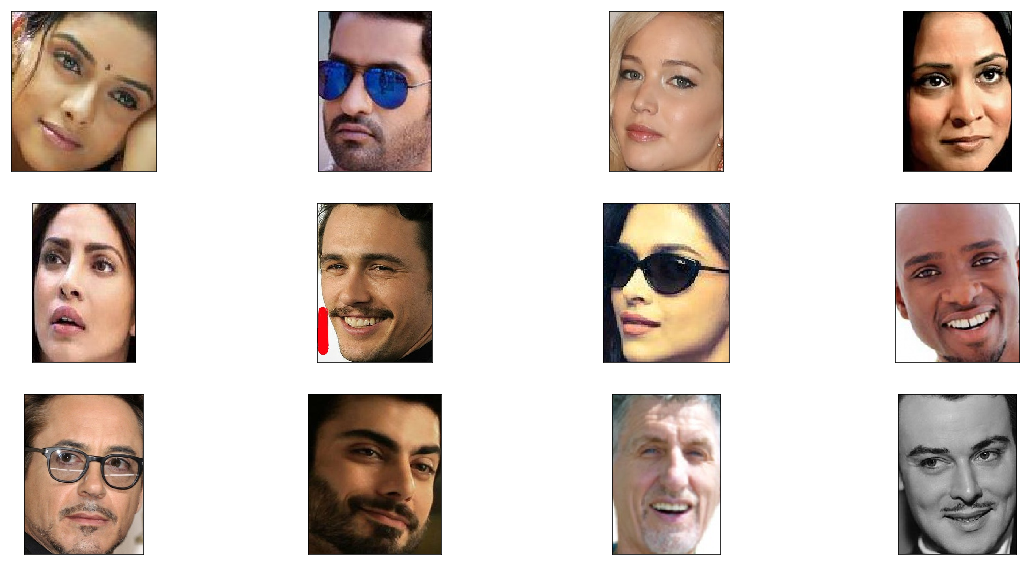

In [0]:
#Visualize the First 12 Training Images
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)


##Pre-process the Data
When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$
The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$
Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!



##Making Predictions
Getting the 4D tensor ready for any pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function preprocess_input. If you're curious, you can check the code for preprocess_input [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

In [0]:
from keras.preprocessing import image 
from keras.applications.mobilenet import preprocess_input
from tqdm import tqdm

#Method to process a single image
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    #img = preprocess_input(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

#Method to process array of images
#Also we are using reprocess_input for resnet 50
def paths_to_tensor(img_paths):
    list_of_tensors = [preprocess_input(path_to_tensor(img_path)) for img_path in tqdm(img_paths)]
    #print(list_of_tensors[0].shape)
    #print(np.vstack(list_of_tensors[0].shape))
    return np.vstack(list_of_tensors)

### Create tensors for passing them for training

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np

# load tensors
train_tensors = paths_to_tensor(train_files).astype('float32')
valid_tensors = paths_to_tensor(valid_files).astype('float32')
test_tensors = paths_to_tensor(test_files).astype('float32')
print (train_tensors[0].shape)
print (type(train_tensors))

100%|██████████| 340/340 [00:01<00:00, 245.31it/s]


(224, 224, 3)
<class 'numpy.ndarray'>


### Create tensors for testing

In [0]:
# load tensors for testing
train_tensors_255 = paths_to_tensor(train_files).astype('float32')/255
valid_tensors_255 = paths_to_tensor(valid_files).astype('float32')/255
test_tensors_255 = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 340/340 [00:01<00:00, 255.34it/s]


### Creating generators for training and evaluating

In [0]:

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)#We do not augment validation data. we only perform rescale

#Create the image generators
train_generator = train_datagen.flow(train_tensors, train_targets,batch_size=47)
val_generator = val_datagen.flow(valid_tensors, valid_targets, batch_size=47)
test_generator = test_datagen.flow(test_tensors, test_targets, batch_size=47)

### Printing labels

In [0]:
generator= train_datagen.flow_from_directory("dataset1/train", batch_size=47)
label_map = (generator.class_indices)
print(label_map)

Found 1600 images belonging to 2 classes.
{'man': 0, 'woman': 1}


### Downloading MobileNet_V2

In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2

HEIGHT = 224
WIDTH = 224

base_model = MobileNetV2(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 2s 0us/step


### Creating a custon classifier with the use of the above base model
This is how transfer learning occurs in Keras models

In [0]:
#Custom Model

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Define the architecture.

print (train_tensors.shape)
'Here we add the base model without the last layers'
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
#WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
#Instructions for updating:
#Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
#model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(train_tensors.shape[1:]) ))
#model.add(MaxPooling2D(pool_size=3))
#model.add(Dropout(0.2))
#model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))
#model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))
#model.add(GlobalAveragePooling2D(data_format=None))
model.add(Dense(2, activation='softmax'))

model.summary()

(1600, 224, 224, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               32113152  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 5

### We compile and train the model

Number of trainable weights before freezing: 162
Number of trainable weights after freezing: 6
Instructions for updating:
Use tf.cast instead.
Epoch 1/24
100/100 [==============================] - 73s 731ms/step - loss: 0.5657 - acc: 0.7265 - val_loss: 0.4609 - val_acc: 0.7739

Epoch 00001: val_loss improved from inf to 0.46093, saving model to gender_mobilenet.weights.best.hdf5
Epoch 2/24
100/100 [==============================] - 62s 616ms/step - loss: 0.4271 - acc: 0.8086 - val_loss: 0.4108 - val_acc: 0.8318

Epoch 00002: val_loss improved from 0.46093 to 0.41080, saving model to gender_mobilenet.weights.best.hdf5
Epoch 3/24
100/100 [==============================] - 62s 618ms/step - loss: 0.3418 - acc: 0.8538 - val_loss: 0.4117 - val_acc: 0.8224

Epoch 00003: val_loss did not improve from 0.41080
Epoch 4/24
100/100 [==============================] - 61s 614ms/step - loss: 0.3353 - acc: 0.8556 - val_loss: 0.3876 - val_acc: 0.8332

Epoch 00004: val_loss improved from 0.41080 to 0.387

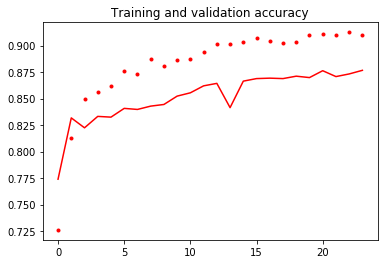

<Figure size 432x288 with 0 Axes>

In [0]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint  
import matplotlib.pyplot as plt

##Freeze the base_model and train only our own.
print('Number of trainable weights before freezing:',len(model.trainable_weights))
#base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
print('Number of trainable weights after freezing:',len(model.trainable_weights))

adam = SGD(lr=0.001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='gender_mobilenet.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpoint]

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=24,
                              validation_data=val_generator,
                              validation_steps=100,
                              shuffle=True, callbacks=callbacks_list)

# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')
    
plot_training(history)

### We load the weights of the best model
Also there is a creation of a function to get predictions from the model

In [0]:
'Load weights'
model.load_weights('gender_mobilenet.weights.best.hdf5')

def MobileNet_V2_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    #print(img.shape)
    
    
    
    ##ATTENTION 255
    return np.argmax(model.predict(img/255))

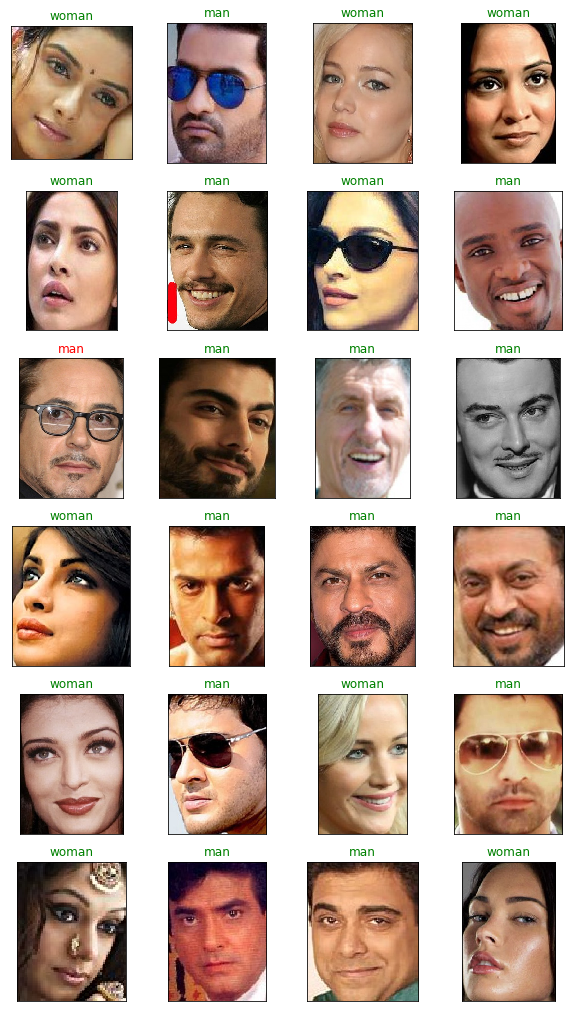

In [0]:
fig = plt.figure(figsize=(10, 18))
for i in range(24):
    ax = fig.add_subplot(6, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)
    #print(MobileNet_V2_predict_labels(train_files[i]))
    
    if MobileNet_V2_predict_labels(train_files[i]) == 1 and train_targets[i][1] == 1:
        ax.set_title("woman", color = "green")
    elif MobileNet_V2_predict_labels(train_files[i]) == 1 and train_targets[i][1] == 0:
        ax.set_title("woman", color = "red")
    elif MobileNet_V2_predict_labels(train_files[i]) == 0 and train_targets[i][1] == 0:
        ax.set_title("man", color = "green")
    elif MobileNet_V2_predict_labels(train_files[i]) == 0 and train_targets[i][1] == 1:
        ax.set_title("man", color = "red")


#for i in train_filew[:12]:
  #print(Mobile_V2_predict_labels(i))

In [0]:
# load the weights that yielded the best validation accuracy
mobile_net_model = model
#mobile_net_model.load_weights('gender_mobilenet.weights.best.hdf5')

### Keras to tensorflow .pb files

In [0]:
import os
import tensorflow as tf
import keras.backend as K

'Method for saving keras to tensorflow to a specific directory'
def keras_to_tensorflow(keras_model, output_dir, model_name,out_prefix="output_", log_tensorboard=True):

    if os.path.exists(output_dir) == False:
        os.mkdir(output_dir)

    out_nodes = []

    for i in range(len(keras_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(keras_model.output[i], out_prefix + str(i + 1))

    sess = K.get_session()

    from tensorflow.python.framework import graph_util, graph_io

    init_graph = sess.graph.as_graph_def()

    main_graph = tf.compat.v1.graph_util.convert_variables_to_constants(sess, init_graph, out_nodes)

    graph_io.write_graph(main_graph, output_dir, name=model_name, as_text=False)

    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard

        import_pb_to_tensorboard.import_to_tensorboard(
            os.path.join(output_dir, model_name),
            output_dir)
        
'Load weights'
mobile_net_model.load_weights('gender_mobilenet.weights.best.hdf5')

'Make directory'
output_dir = os.path.join(os.getcwd(),"checkpoint")

'Saving to Tensorflow'
keras_to_tensorflow(mobile_net_model,output_dir=output_dir,model_name="keras_gender.pb")

print("Success!")

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 266 variables.
INFO:tensorflow:Converted 266 variables to const ops.
Instructions for updating:
Use tf.gfile.GFile.
Model Imported. Visualize by running: tensorboard --logdir=/content/checkpoint
Success!


### Getting Tensorboard to see the graph

In [0]:
#Using Tensorboard to see graph
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-04-12 12:08:09--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.172.177.65, 34.232.40.183, 34.226.180.131, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.172.177.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  75.8MB/s    in 0.2s    

2019-04-12 12:08:09 (75.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
#Info: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

#let's fire up the TensorBoard in the background like this:
LOG_DIR = 'checkpoint'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
#Then, we can run ngrok to tunnel TensorBoard port 6006 to the outside world. This command also runs in the background.
get_ipython().system_raw('./ngrok http 6006 &')
#One last step, we get the public URL where we can access the colab TensorBoard web page.
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    
#Click genarated address to visualize graph of model and see the names of the input and output nodes to use them inside android app.

http://fd89bfa9.ngrok.io


## Keras to .tflite

In [0]:
# Convert to TensorFlow Lite model.
converter = tf.contrib.lite.TFLiteConverter.from_keras_model_file("gender_mobilenet.weights.best.hdf5")
tflite_model = converter.convert()
open("keras_gender.tflite", "wb").write(tflite_model)

INFO:tensorflow:Froze 266 variables.
INFO:tensorflow:Converted 266 variables to const ops.


137832704

### Using test set to find accuracy

In [0]:
# Use test set to find accuracy
gender_predictions = [np.argmax(mobile_net_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors_255]

# report test accuracy
test_accuracy = 100*np.sum(np.array(gender_predictions)==np.argmax(test_targets, axis=1))/len(gender_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 87.6471%


### Testing final model for its predictions with the test set

In [0]:
'Load weights'
mobile_net_model.load_weights('gender_mobilenet.weights.best.hdf5')

def MobileNet_V2_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    #print(img.shape)
    return np.argmax(mobile_net_model.predict(img/255))

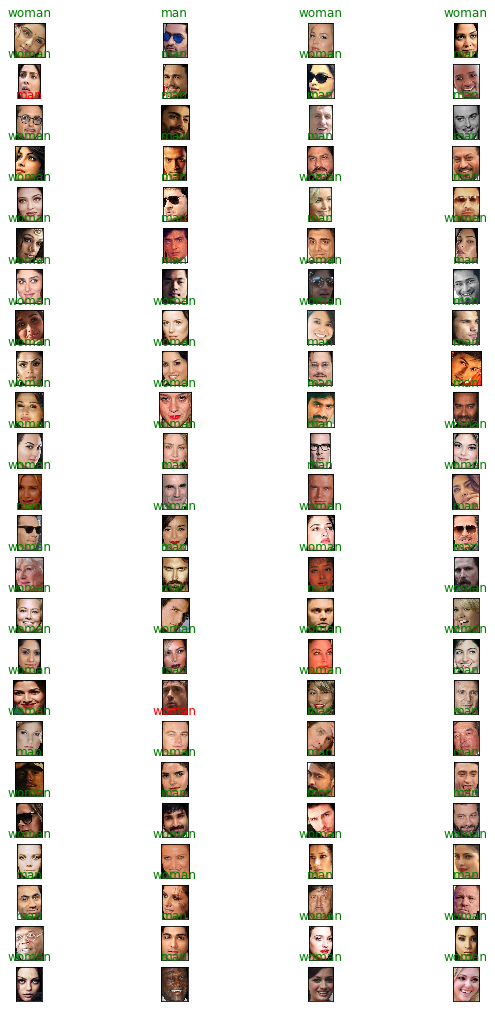

In [0]:
fig = plt.figure(figsize=(10, 18))
for i in range(96):
    ax = fig.add_subplot(24, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)
    #print(MobileNet_V2_predict_labels(train_files[i]))
    
    if MobileNet_V2_predict_labels(train_files[i]) == 1 and train_targets[i][1] == 1:
        ax.set_title("woman", color = "green")
    elif MobileNet_V2_predict_labels(train_files[i]) == 1 and train_targets[i][1] == 0:
        ax.set_title("woman", color = "red")
    elif MobileNet_V2_predict_labels(train_files[i]) == 0 and train_targets[i][1] == 0:
        ax.set_title("man", color = "green")
    elif MobileNet_V2_predict_labels(train_files[i]) == 0 and train_targets[i][1] == 1:
        ax.set_title("man", color = "red")


#for i in train_filew[:12]:
  #print(Mobile_V2_predict_labels(i))

In [0]:
#############################################################################################